## Comparsion between MITgcm output and lab experiment

||MITgcm model|Lab experiment|
|:-:|:-:|:-:|
|**Date**|01-Jul-20| 19-Dec-20 |
|**Run**| BF4_from_PIV_two_can/run01| T14|
|**f (s$^{-1}$)**| 0.7 |0.7 to 0.74 to 0.78|
|**Density profile**|From interp. measurements|From interp. measurements|
|**N at sb depth (s$^{-1}$)**|1.86|1.86|
|**Max U (cm s$^{-1}$)** |||

In [1]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
import scipy.interpolate 
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import conduino_tools as ctools

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Sections to add:
    
Incoming flow (forcing)

Velocity field at shelf break depth

Velocity field below shelf break depth

Density change at canyon head

### Functions

In [2]:
def calc_rho(RhoRef, T, S, alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 4D arrays 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho

def calc_N(density, depth, RhoRef):
    '''Calculate buoyancy frequency from density and depth vectors'''
    g = 9.81
    N = ((g/RhoRef)*(-(density[2:]-density[:-2])/(depth[2:]-depth[:-2])))**0.5 
    return(N, depth[1:-1])

def rho_virtual_probe(state_xarray,time_slice,probe_z_ind, probe_r_ind,probe_axis_ind, RhoRef):
    '''INPUT
       state_xarray: xarray dataset from state file
       time_slice: slice in time dimension as in slice(t0,tf).
       probe_z_ind: int: vertical index of virtual probe
       probe_r_ind: int: radial index of virtual probe
       probe_axis_ind: int: canyon axis index (azimuthal)
       RhoRef: float: Reference densitty form the model
       
       OUTPUT
       probe_rho: array of length time slice with density values
       '''
    probe_sal = np.mean(np.mean(state_xarray.S[time_slice,probe_z_ind,probe_r_ind-2:probe_r_ind+2,probe_axis_ind-2:probe_axis_ind+2].data,axis=1),axis=1)
    probe_temp = np.mean(np.mean(state_xarray.Temp[time_slice,probe_z_ind,probe_r_ind-2:probe_r_ind+2,probe_axis_ind-2:probe_axis_ind+2].data,axis=1),axis=1)
    probe_rho = calc_rho(RhoRef, probe_temp, probe_sal)
    return(probe_rho)

def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v



In [3]:
## Useful grid variables from the model

# Open glued grid file
grid = xr.open_dataset('/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/gridGlob.nc')
R = grid.Y
R_v = grid.Yp1

Th = np.pi*grid.X/180
Th_u = np.pi*grid.Xp1/180

nr = np.shape(grid.Y)[0]
nth = np.shape(grid.X)[0]

XX = R*np.cos(Th)
YY = R*np.sin(Th)

HFacCMasked = np.ma.masked_where(grid.HFacC == 0, grid.HFacC)
maskC = np.ma.getmask(HFacCMasked)

HFacWMasked = np.ma.masked_where(grid.HFacW == 0, grid.HFacW)
maskW = np.ma.getmask(HFacWMasked)

RC = grid.RC[:].data

# Useful indices
sb_ind = 124
off_shore_ind = sb_ind-50
mid_ind = 160
probe_ind = 205
axis_ind = 283
axis_ind_dns = 228
z_probe_ind = 24
z_sb_ind = int(29.5/0.5)

## Stratification

Samples from the lab at 10 depths measured with the Aanton par lab densimeter vs. initial density profile from the  model. I interpolated the density measurements to initialize the model so they should match.

In [4]:
# Load density measurements from lab
df = pd.read_csv('/ocean/kramosmu/MultipleCanyons/lab/Conduino/experiments/exp_19dec19/densities_T14.csv')

# Open glued state file from model
state = xr.open_dataset('/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/stateGlob.nc')

In [5]:
# Get initial density profile from model
RhoRef = 999.79998779 

S0 = state.S[0,:,off_shore_ind,axis_ind_dns].data # Initial off-shelf salinity profile 
S0_mskd = np.ma.masked_array(S0, mask=maskC[:,off_shore_ind,axis_ind_dns])
T0 = state.Temp[0,:,off_shore_ind,axis_ind_dns].data # Initial off-shelf temperature profile 
T0_mskd = np.ma.masked_array(T0, mask=maskC[:,off_shore_ind,axis_ind_dns])
    
Rho0_model = calc_rho(RhoRef,T0_mskd,S0_mskd)

## Calculate buoyancy frequency N
N_model, depthN_model = calc_N(Rho0_model, RC, RhoRef)

In [6]:
## Interpolate lab density to plot
depth_model = np.append(np.linspace(0,8,160),np.linspace(8,9.5,15))
func_rho = scipy.interpolate.interp1d(df.depth,df.density1[:],kind='linear',fill_value='extrapolate')
interp_rho = func_rho(depth_model)

## Calculate buoyancy frequency N
N_lab, depthN_lab = calc_N(1000*interp_rho, -depth_model/100.0, RhoRef)

Lab N is 1.519758 1/s at shelf break depth -3.018868 cm
Model N is 1.524531 1/s at shelf break depth -3.025000 cm


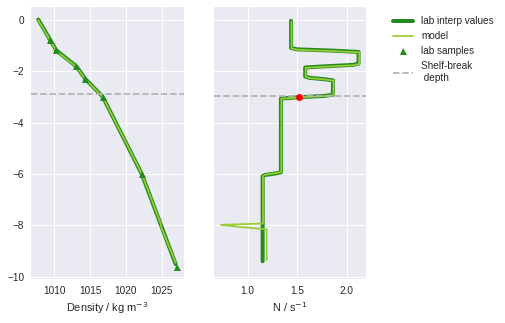

In [9]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(6,5), sharey=True)

ax2.plot(1000*interp_rho, -depth_model, '-',color='forestgreen',linewidth=4,label='lab interp values')
ax2.plot(Rho0_model, 100*RC, '-',color='yellowgreen',label='model')
ax2.plot(1000*df.density1[:], -df.depth, '^',color='forestgreen',label='lab samples')
ax2.axhline(-2.9, color='0.7', linestyle='--', label='Shelf-break \n depth')
ax2.set_xlabel('Density / kg m$^{-3}$')

ax3.plot(N_lab, depthN_lab*100, '-',color='forestgreen',linewidth=4,label='N lab from interp rho')
ax3.plot(N_model, depthN_model*100, '-',color='yellowgreen',label='N model')

ax3.axhline(-depth_model[z_sb_ind], color='0.7', linestyle='--', label='Shelf-break \n depth')

#print(f'Lab N is {N_lab[z_sb_ind]} 1/s at shelf break depth {depthN_lab[z_sb_ind]*100} cm')
#print(f'Model N is {N_model[z_sb_ind]} 1/s at shelf break depth {depthN_model[z_sb_ind]*100} cm')
print('Lab N is %f 1/s at shelf break depth %f cm' %(N_lab[z_sb_ind],depthN_lab[z_sb_ind]*100))
print('Model N is %f 1/s at shelf break depth %f cm' %(N_model[z_sb_ind],depthN_model[z_sb_ind]*100))

ax3.plot(N_lab[z_sb_ind], depthN_lab[z_sb_ind]*100,'ro')
ax3.set_xlabel('N / s$^{-1}$')
ax2.legend(bbox_to_anchor=(3.1,1))

## Density change at canyon head

Conduino measurements vs density at a virtual station (three different depths from the bottom) at the canyons' heads. The virtual station is the average of 4 cells. 

See plot below where probe_ind, axis_ind and axis_ind_dns are defined. Indices of the probes locations are (z_probe_ind, probe_ind, axis_ind) for the upstream canyon and (z_probe_ind, probe_ind, axis_ind_dns) for the downstream canyon.

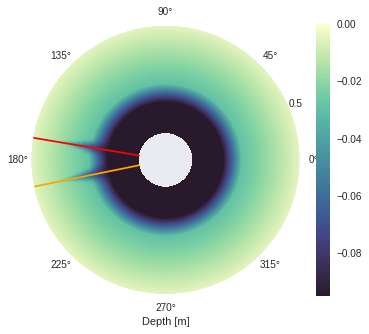

Shelf break radius 
28.792452830188687
probe depth
-1.2250000000000008
Bottom depth at probe location
-1.510969723562966


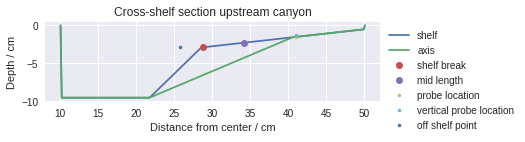

In [10]:
# Depth plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection='polar'),figsize=(6,5))

pcm1 = ax.pcolormesh(Th,R,-grid.Depth,cmap=cmo.cm.deep_r)
cb = plt.colorbar(pcm1,ax=ax)
ax.plot(np.ones_like(R)*Th[axis_ind].data,R[:], color='orange')
ax.plot(np.ones_like(R)*Th[axis_ind_dns].data,R[:], color='red')
ax.set_xlabel(r'Depth [m]')
plt.show()

# Shelf cross-section
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.plot(R*100,-grid.Depth[:,20]*100,'-', label='shelf')
ax.plot(R*100,-grid.Depth[:,axis_ind]*100,'-',label='axis')
ax.plot(R[sb_ind]*100,-grid.Depth[sb_ind,20]*100,'o', label='shelf break')
ax.plot(R[mid_ind]*100,-grid.Depth[mid_ind,20]*100,'o', label='mid length')
ax.plot(R[probe_ind]*100,-grid.Depth[probe_ind,20]*100,'.', label='probe location')
ax.plot(R[probe_ind]*100,grid.RC[z_probe_ind]*100,'.', label='vertical probe location')
ax.plot(R[sb_ind-20]*100,-grid.Depth[sb_ind,20]*100,'.', label='off shelf point')

ax.set_xlabel(r'Distance from center / cm')
ax.set_ylabel(r'Depth / cm')
ax.set_title('Cross-shelf section upstream canyon')
ax.set_aspect(1)
ax.legend(bbox_to_anchor=(1,1))
print('Shelf break radius ') 
print(100*R[sb_ind].data)
print('probe depth')
print(100*grid.RC[z_probe_ind].data)
print('Bottom depth at probe location')
print(-grid.Depth[probe_ind,20].data*100)

In [11]:
# Get density at virtual stations
tslice=slice(0,17)

# Upstream, 3 depths
probe1_rho1 = rho_virtual_probe(state, tslice, z_probe_ind+2, probe_ind, axis_ind, RhoRef)
probe1_rho2 = rho_virtual_probe(state, tslice, z_probe_ind+3, probe_ind, axis_ind, RhoRef)
probe1_rho3 = rho_virtual_probe(state, tslice, z_probe_ind+4, probe_ind, axis_ind, RhoRef)

# Downstream, 3 depths
probe2_rho1 = rho_virtual_probe(state, tslice, z_probe_ind+2, probe_ind, axis_ind_dns, RhoRef)
probe2_rho2 = rho_virtual_probe(state, tslice, z_probe_ind+3, probe_ind, axis_ind_dns, RhoRef)
probe2_rho3 = rho_virtual_probe(state, tslice, z_probe_ind+4, probe_ind, axis_ind_dns, RhoRef)

In [13]:
# Get conduino timeseries

filepath = '/ocean/kramosmu/MultipleCanyons/lab/Conduino/experiments/exp_19dec19/04_experiment.mat'
mat = sio.loadmat(filepath, squeeze_me=True)
P1 = mat['ch1']
P2 = mat['ch2']
time = mat['time']
dens1 = ctools.densANK1_05Dec19(P1)
dens2 = ctools.densANK2_05Dec19(P2)

f0 = (0.7/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
fs = len(time)/np.max(time) # Sampling frequency in Hz
ups_rho_lab = 1000*(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)) # kg/m^3
dns_rho_lab = 1000*(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)) # kg/m^3

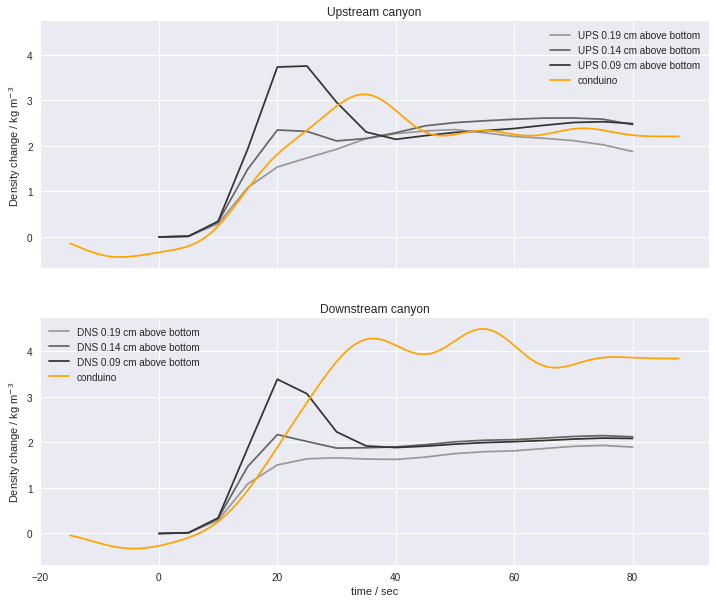

In [19]:
# Plot time series

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)

time_model = np.arange(17)*5
probe_bot_depth = grid.Depth[probe_ind,axis_ind].data

ax1.plot(time_model,probe1_rho1[:]-probe1_rho1[0], color='0.6',
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+2])))
ax1.plot(time_model,probe1_rho2[:]-probe1_rho2[0], color='0.4',
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+3])))
ax1.plot(time_model,probe1_rho3[:]-probe1_rho3[0], color='0.2',
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
ax1.plot(time[0:2400]-15, ups_rho_lab, color='orange', label = 'conduino')
ax1.set_title('Upstream canyon')

ax2.plot(time_model,probe2_rho1[:]-probe2_rho1[0], color='0.6', 
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+2])))
ax2.plot(time_model,probe2_rho2[:]-probe2_rho2[0], color='0.4', 
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+3])))
ax2.plot(time_model,probe2_rho3[:]-probe2_rho3[0], color='0.2',
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
ax2.plot(time[0:2400]-15, dns_rho_lab, color='orange', label = 'conduino')
ax2.set_title('Downstream canyon')

ax.axvline(21,linestyle='--', color='0.5')
ax.axvline(71,linestyle='--', color='0.5')

ax.set_xlim(0,80)
ax1.set_ylabel(r'Density change / kg m$^{-3}$')
ax2.set_ylabel(r'Density change / kg m$^{-3}$')
ax2.set_xlabel('time / sec')
ax1.legend()
ax2.legend()